**Auswertung:**

- Es ist längeres Training nötig, da Q-Values noch nicht stabil sind (d.h. mehr als 10000 Episoden)

In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [3]:
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

In [5]:
fig_width = 16

In [6]:
dirnames = ["../checkpoints/b001/",
            "../checkpoints/s141/20210512-2058/",
            "../checkpoints/s142/20210512-2059/",
            "../checkpoints/s143/20210511-2126/"]

In [7]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [8]:
q_values = vh.load_and_convert_q_values(dirnames)

No Q-value list found for ../checkpoints/b001/.
No Q-value list found for ../checkpoints/s142/20210512-2059/.
No Q-value list found for ../checkpoints/s143/20210511-2126/.


In [9]:
vh.get_arguments_overview(dirnames)

b001  \
algorithm                           baseline_rule-based   
lr                                                 0.01   
discount_factor                                     0.9   
batch_size                                          128   
reward_offset                                       0.0   
stp_reward_step_offset                              0.0   
target_network_update_freq                            3   
epsilon_final_step                                  100   
episodes_count                                      100   
agent_network                    2HiddenLayer,Trapezium   
agent_init_gain                                     0.8   
agent_w_l2                                        1e-05   
network_storage_frequency                            10   
shared_network_per_agent_class                        0   
model                           Building_5ZoneAirCooled   

                                                                  s141  \
algorithm                                                         ddqn   
lr                                                               0.045   
discount_factor                                                   0.75   
batch_size                                                         512   
reward_offset                                                      0.1   
stp_reward_step_offset                                             1.0   
target_network_update_freq                                           4   
epsilon_final_step                                                9400   
episodes_count                                                      88   
agent_network                              2HiddenLayer,Trapezium,SiLU   
agent_init_gain                                                    0.6   
agent_w_l2                                                       5e-07   
network_storage_frequency                                           88   
shared_network_per_agent_class                                       1   
model                           Building_5ZoneAirCooled_SingleSetpoint   

                                                                  s142  \
algorithm                                                         ddqn   
lr                                                                0.05   
discount_factor                                                   0.75   
batch_size                                                         512   
reward_offset                                                      0.1   
stp_reward_step_offset                                             1.0   
target_network_update_freq                                           4   
epsilon_final_step                                                9400   
episodes_count                                                      88   
agent_network                              2HiddenLayer,Trapezium,SiLU   
agent_init_gain                                                    0.6   
agent_w_l2                                                       1e-06   
network_storage_frequency                                           88   
shared_network_per_agent_class                                       1   
model                           Building_5ZoneAirCooled_SingleSetpoint   

                                                                  s143  
algorithm                                                         ddqn  
lr                                                               0.025  
discount_factor                                                   0.75  
batch_size                                                         256  
reward_offset                                                      0.1  
stp_reward_step_offset                                             1.0  
target_network_update_freq                                           4  
epsilon_final_step                                                6330  
episodes_count                                                      88  
agent_

In [10]:
vh.get_runtime_overview_df(alldfs, dirnames)

b001          s141  \
Number of training episodes                      1.0   9768.000000   
Runtime in s                                     0.0  47378.506160   
Runtime in h                                     0.0     13.160696   
Mean episode runtime in s                        0.0      4.850379   
Mean episode runtime during eval. episode in s   0.0      5.022364   
Mean episode runtime after eval. episode in s    NaN      4.770624   
Mean episode runtime in no eval. episode in s    NaN      4.848403   

                                                        s142          s143  
Number of training episodes                      7920.000000   3721.000000  
Runtime in s                                    41824.071796  18168.764655  
Runtime in h                                       11.617798      5.046879  
Mean episode runtime in s                           5.280817      4.882764  
Mean episode runtime during eval. episode in s      5.572624      5.077014  
Mean episode runtime after eval. episode in s       5.160299      4.793687  
Mean episode runtime in no eval. episode in s       5.277463      4.880546

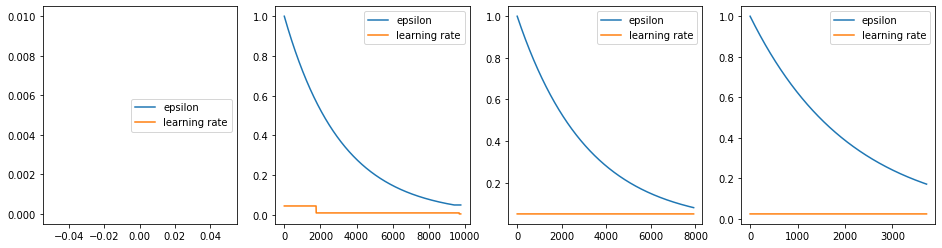

In [11]:
p, _ = vh.complete_plot_epsilon(alldfs, fig_width)
p.show()

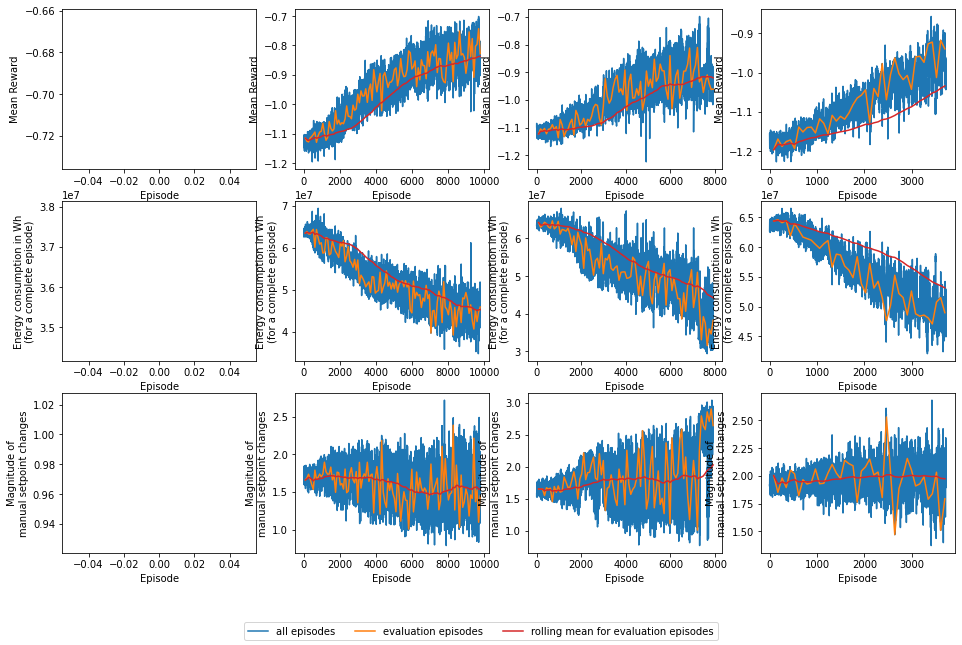

In [12]:
p, _ = vh.complete_plot_reward_stpc_econs(alldfs, fig_width)
p.show()

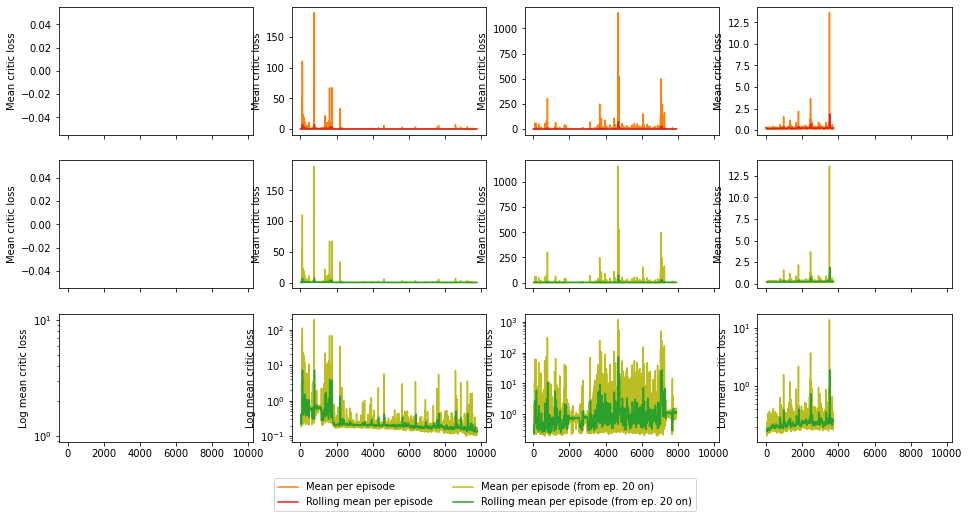

In [13]:
p, _ = vh.complete_plot_losses(alldfs, fig_width, with_agents=False)
p.show()

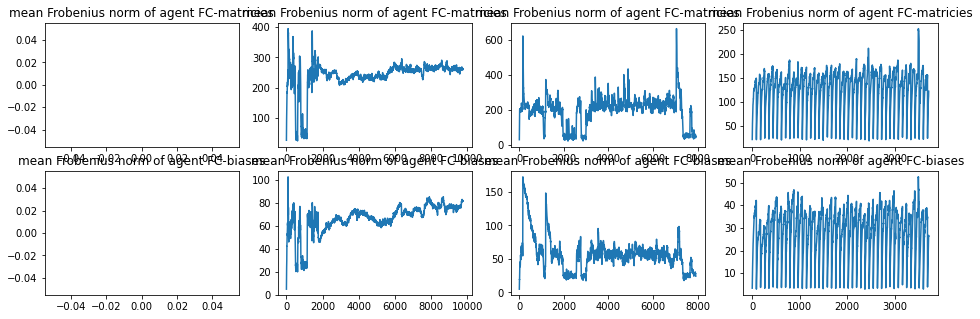

In [14]:
p, _ = vh.complete_plot_frobenius_norms(alldfs, fig_width, with_critics=False)
p.show()

In [15]:
last_available_eval_episodes = vh.compute_last_available_eval_episode(alldfs)

Last available evaluation episode for dfs0:      0
Last available evaluation episode for dfs1:   9767
Last available evaluation episode for dfs2:   7919
Last available evaluation episode for dfs3:   3695


<h3>Details for one week</h3>

In [16]:
#selected_episodes = [13120 - 1, 14480 - 1, 14480 - 1]
#selected_weeks    = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1)]

In [17]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = vh.select_week_and_episode_for_dfs_list(alldfs, selected_episodes, selected_weeks)

In [18]:
vh.print_reward_informations(subdfs, selected_episodes)

First complete week of evaluation episode
For episode     0: Energy consumption:   36152.82 kWh; Numer of setpoint changes: 700.4556998153214
For episode  9767: Energy consumption:   45926.18 kWh; Numer of setpoint changes: 1039.9128806919812
For episode  7919: Energy consumption:   38263.13 kWh; Numer of setpoint changes: 1901.2297790523326
For episode  3695: Energy consumption:   48989.05 kWh; Numer of setpoint changes: 1289.2381090441056

Mean values for episode ...
...     0: Reward: -0.69766 kWh; Setpoint change magnit.:  0.97421; Energy cons.: 50282.08407
...  9767: Reward: -0.82802 kWh; Setpoint change magnit.:  1.44633; Energy cons.: 63875.07602
...  7919: Reward: -0.96103 kWh; Setpoint change magnit.:  2.64427; Energy cons.: 53217.14379
...  3695: Reward: -0.93997 kWh; Setpoint change magnit.:  1.79310; Energy cons.: 68134.98480


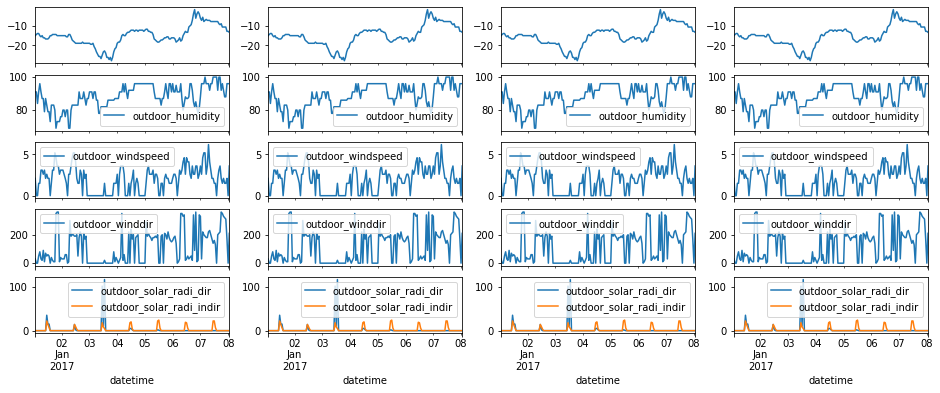

In [19]:
p, _ = vh.complete_plot_weather_information(subdfs, fig_width)
p.show()

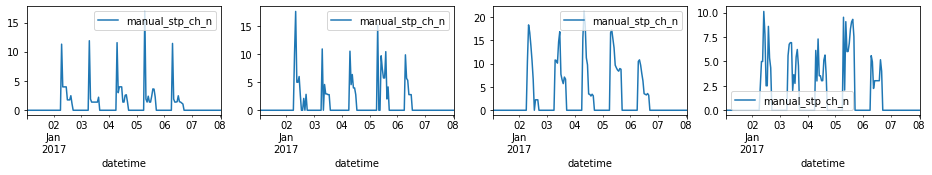

In [20]:
p, _ = vh.complete_plot_number_of_stp_ch(subdfs, fig_width)
p.show()

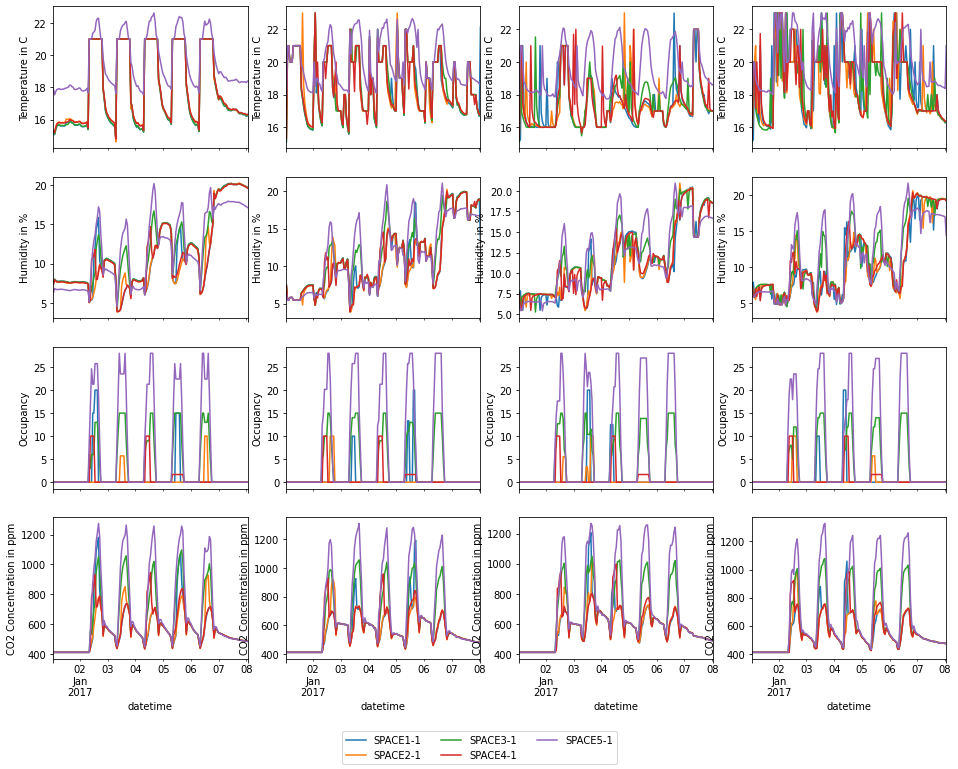

In [21]:
p, _ = vh.complete_plot_room_status(subdfs, fig_width)
p.show()

In [22]:
subdfs_rooms, subdfs_agents = vh.get_available_rooms_and_agents(subdfs)

Available Rooms     in (sub-)dfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs0: [0 1 2 3 4] 

Available Rooms     in (sub-)dfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs1: [0 1 2 3 4] 

Available Rooms     in (sub-)dfs2: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs2: [0 1 2 3 4] 

Available Rooms     in (sub-)dfs3: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs3: [0 1 2 3 4] 



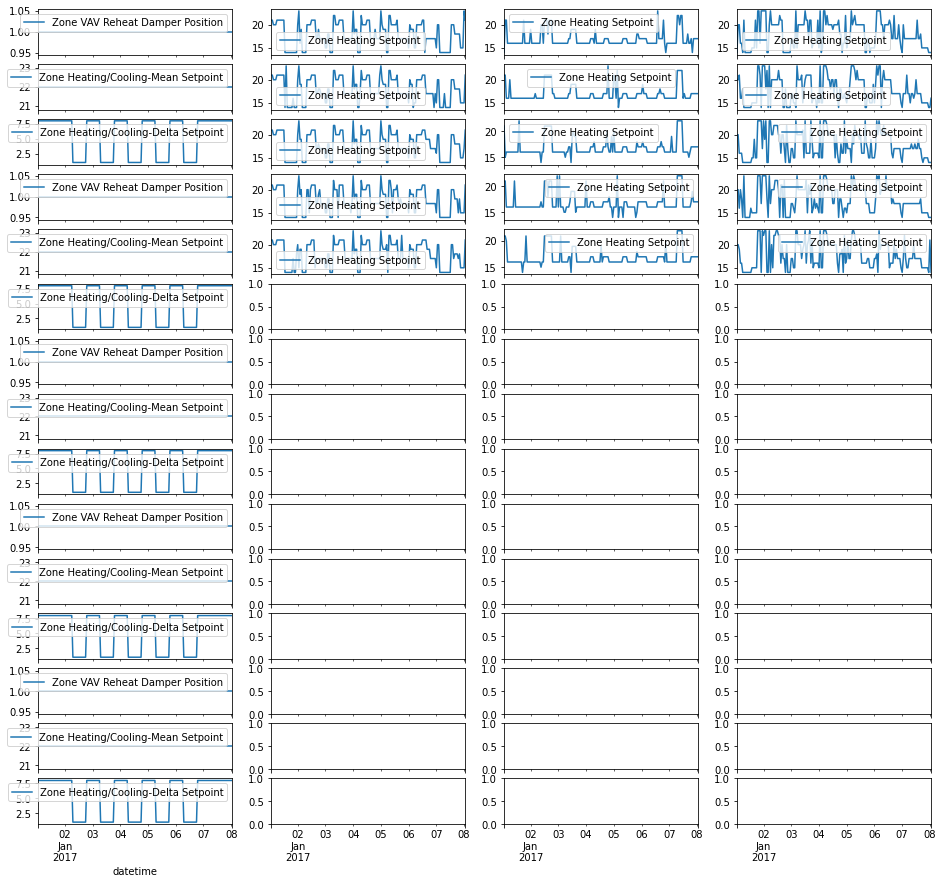

In [23]:
p, _ = vh.complete_plot_all_agent_outputs(subdfs, fig_width, subdfs_agents)
p.show()

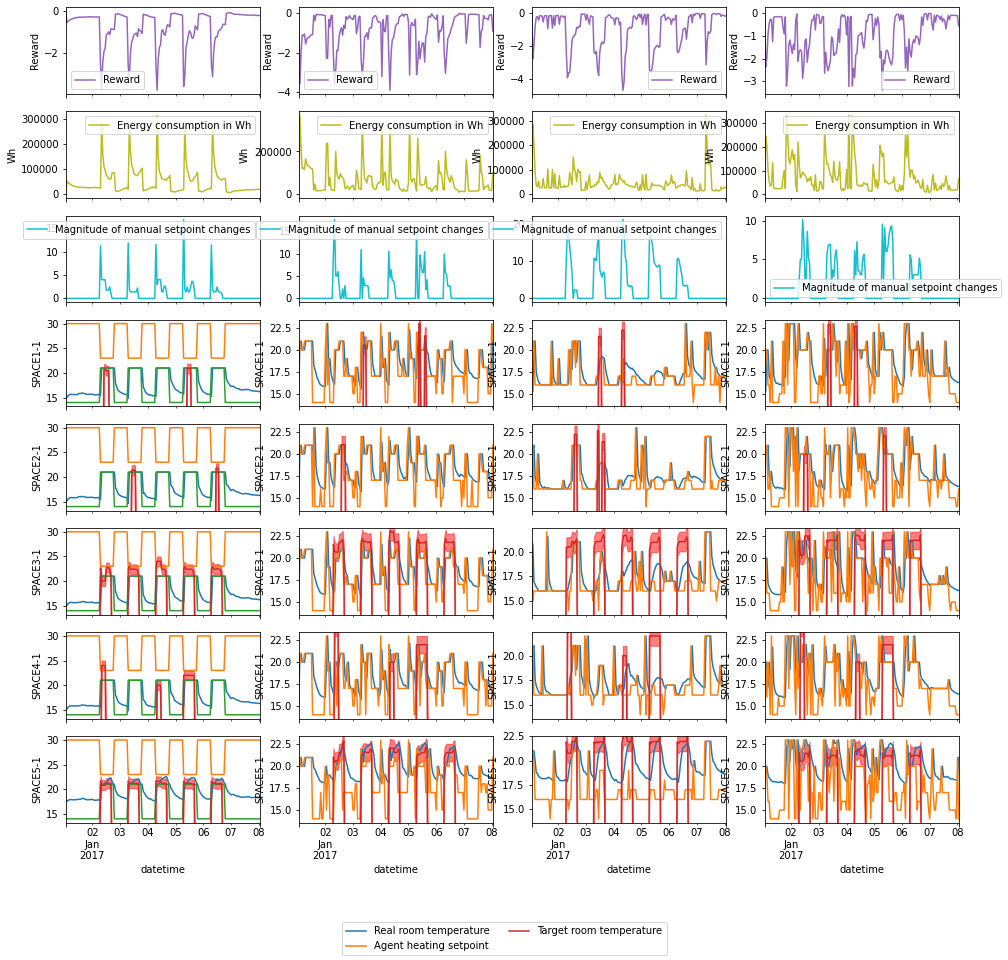

In [24]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a day</h3>

In [25]:
#selected_periods1    = [datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3)]
#selected_periods1_end= [datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4)]

In [26]:
if not "selected_periods1" in locals().keys():
    selected_periods1     = [datetime.datetime(2017, 1, 3) for _ in range(len(alldfs))]
if not "selected_periods1_end" in locals().keys():
    selected_periods1_end = [datetime.datetime(2017, 1, 4) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods1,
            selected_periods1_end)

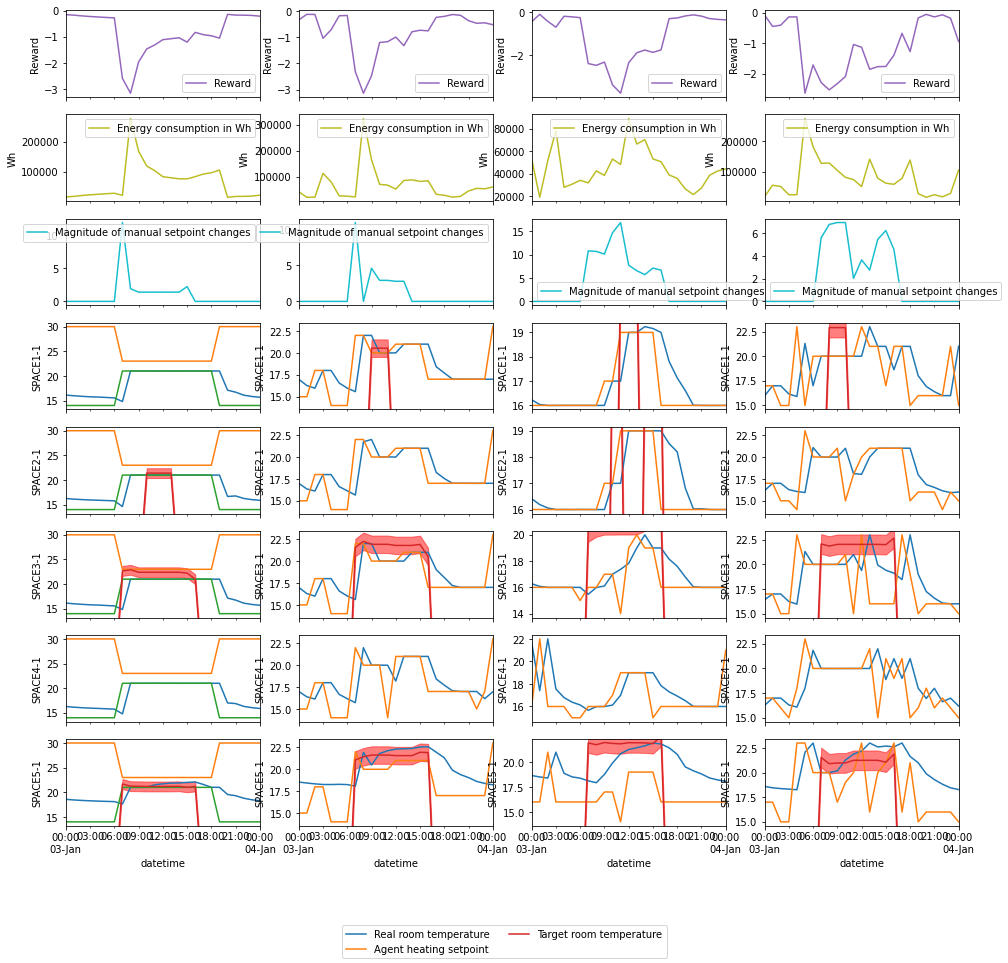

In [27]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a complete month</h3>

In [28]:
#selected_periods2    = [datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1)]

In [29]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods2,
            selected_periods2_end)

For plot number 1, mean energy consumption =  49473.6 Wh, mean reward = -0.6858
For plot number 2, mean energy consumption =  62986.1 Wh, mean reward = -0.8147
For plot number 3, mean energy consumption =  53225.9 Wh, mean reward = -0.9438
For plot number 4, mean energy consumption =  67505.5 Wh, mean reward = -0.9265


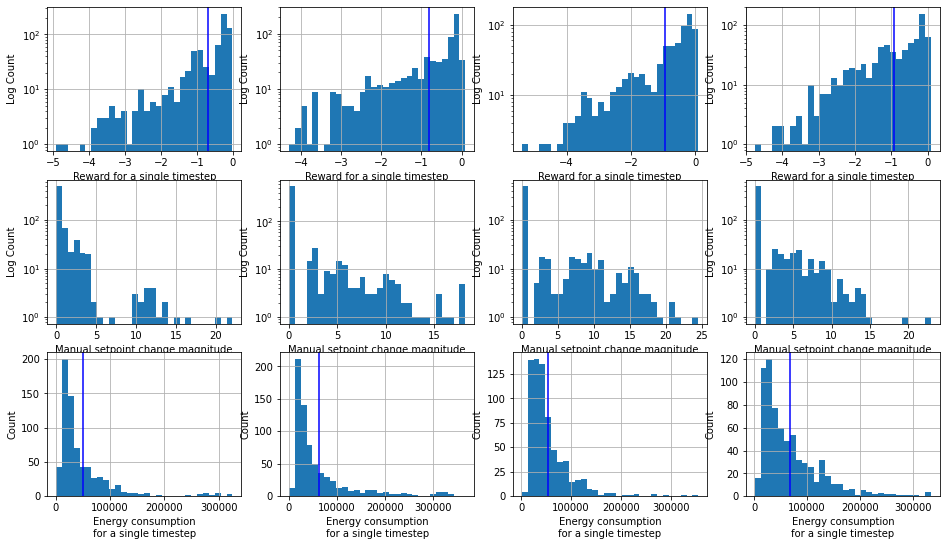

In [30]:
vh.plot_stpch_and_econs_distrib(subdfs, fig_width)

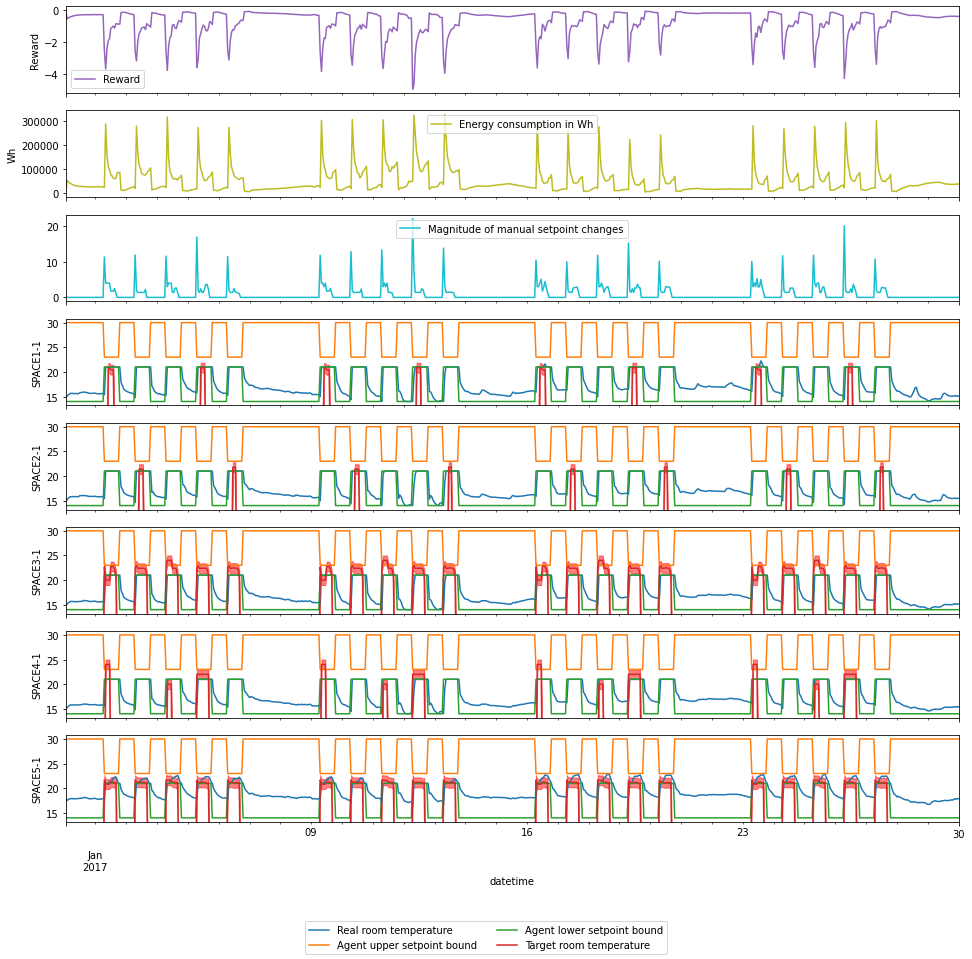

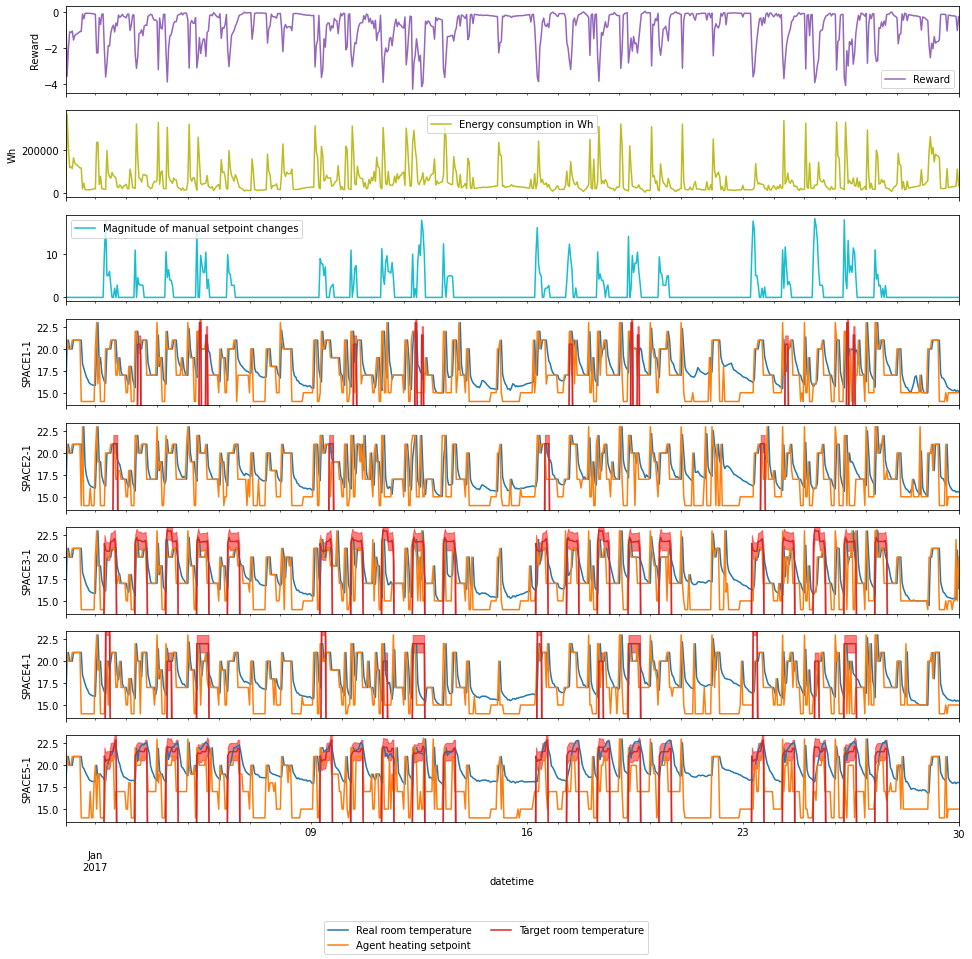

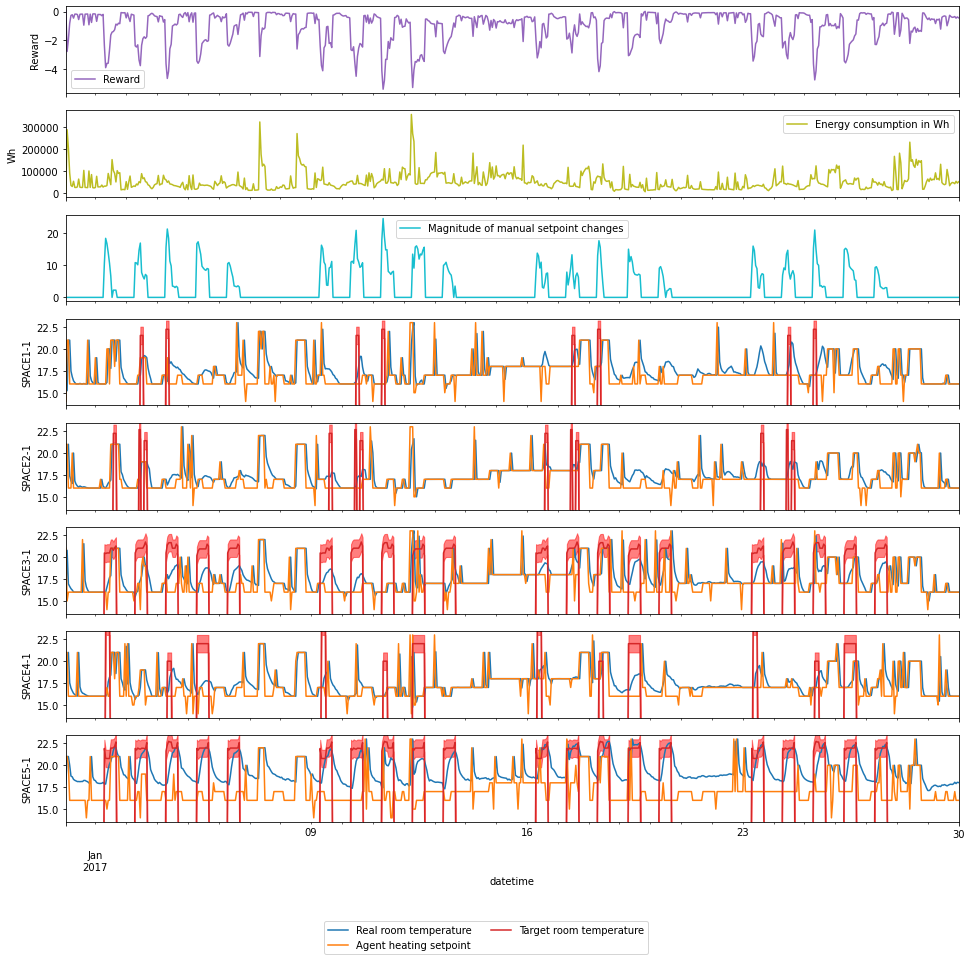

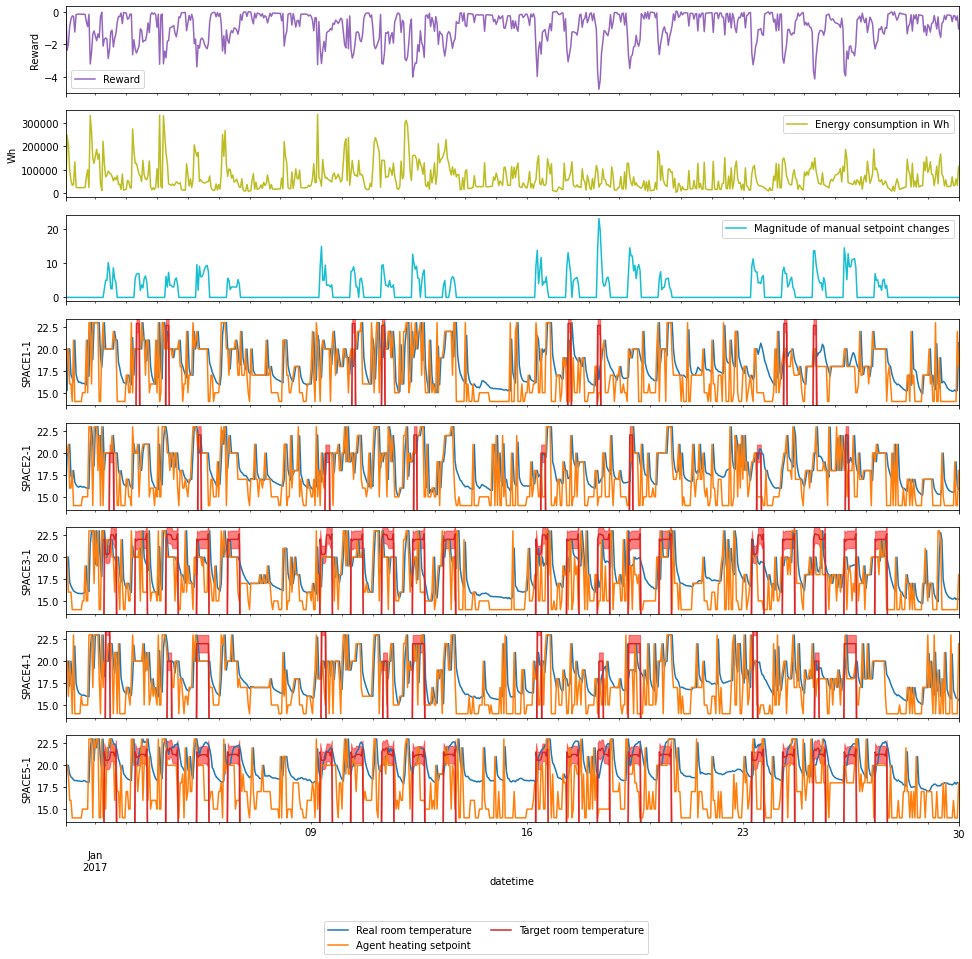

In [31]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()

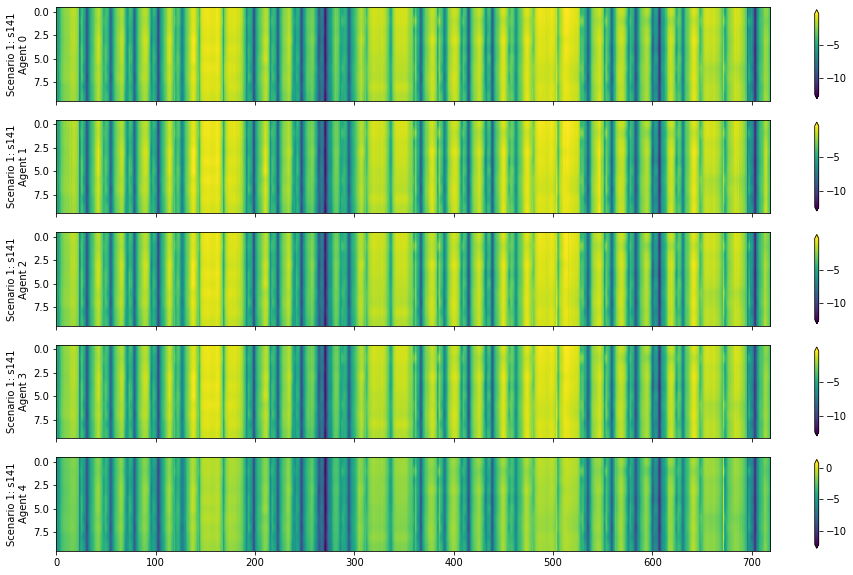

In [32]:
vh.plot_q_values(q_values, fig_width)